In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import mysql.connector

In [3]:
%matplotlib inline

### Begin dictionary of variable types

In [88]:
columns = {'not_needed': ['F_FACILITY', 'MAGE_IMPFLG', 'MAGE_REPFLG', 'MRACE_IMP'],\
          'nominal_categorical':[], 'ordinal_categorical':[], 'continuous':[]}

### Functions to query SQL from python

In [5]:
#function to run simple SQL query from python
def create_table_from_SQL(user, database, password, query):
    '''
    - A function that returns a pandas dataframe from a SQL query in python
    ---------------
    - user: user for your local SQL connection in string format
    - database: schema name where your database is stored in string format
    - password: password to access your local SQL connection in string format
    - query: SQL query in string format; enclose with double quotes and use single quotes
    to designate VARCHAR values within queries; use schema_name.table_name after FROM statement
    '''
    cnx = mysql.connector.connect(user=user, database=database, password=password)
    cursor = cnx.cursor()
    query = query
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = cursor.column_names
    return df

In [10]:
#function to create n number of cursor objects from the SQL dataframe to enable chunking

### Initial Data Analysis

#### *Most frequent defects among NICU admitted patients*

In [7]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ\
        FROM cdc_2018\
        WHERE AB_NICU = 'Y'\
        LIMIT 0, 4000000"

In [8]:
nicu_defect = create_table_from_SQL('root','cdc_project','**********', query)

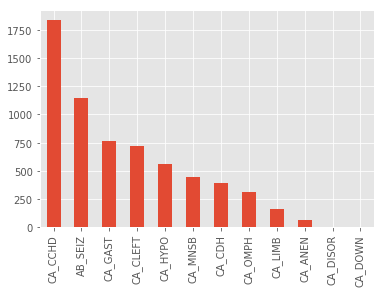

In [9]:
#Cyanotic Congenital Heart Disease, seizures, Gastroschisis show up most frequently among
#NICU admitted patients
nicu_defect.apply(lambda x: sum(x=='Y'), axis=0).sort_values(ascending=False).plot.bar()

#### *Proportion of patients with each defect admitted to NICU vs proportion of non-defect patients admitted - visual results and statistical analysis*